In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
%pwd

'/scratch/local/ssd/bella/msc-project/src/msc_project/experiments/fault_tolerant_boolean_circuits'

In [3]:
base = "/scratch/local/ssd/bella/msc-project"

In [4]:
baseline_path = "results/majority_voting_backdoor/noise_robustness_baseline"
redundancy_1_path = "results/robust_xor_backdoor/noise_robustness_1_small"
redundancy_4_path = "results/majority_voting_backdoor/noise_robustness_redundancy_4_small"
redundancy_2_path = "results/robust_xor_backdoor/majority_voting_1_small"

In [5]:
baseline_results_file = open(f"{base}/{baseline_path}/results.json", "r")
baseline_results_str = baseline_results_file.read()
redundancy_1_results_file = open(f"{base}/{redundancy_1_path}/results.json")
redundancy_1_str = redundancy_1_results_file.read()
redundancy_2_results_file = open(f"{base}/{redundancy_2_path}/results.json")
redundancy_2_str = redundancy_2_results_file.read()
redundancy_4_results_file = open(f"{base}/{redundancy_4_path}/results.json")
redundancy_4_str = redundancy_4_results_file.read()

In [6]:
baseline_json = json.loads(baseline_results_str)
redundancy_1_json = json.loads(redundancy_1_str)
redundancy_4_json = json.loads(redundancy_4_str)
redundancy_2_json = json.loads(redundancy_2_str)

In [7]:
results = []
for (std, r) in baseline_json.items():
    results.append(["baseline", std, r])

for (std, r) in redundancy_1_json.items():
    results.append(["Simple robust XOR", std, r])

for (std, r) in redundancy_2_json.items():
    results.append(["Majority voting + robust XOR", std, r])

for (std, r) in redundancy_4_json.items():
    results.append(["Majority voting with counting XOR", std, r])

In [8]:
results_df = pd.DataFrame(results, columns=["Experiment", "Standard Deviation", "Preservation Rate"])
results_df = results_df.astype({"Experiment": str, "Standard Deviation": "float64"})

In [9]:
results_df.dtypes

Experiment             object
Standard Deviation    float64
Preservation Rate     float64
dtype: object

In [10]:
results_df

,Experiment,Standard Deviation,Preservation Rate
0,baseline,0.001000,1.0
1,baseline,0.001095,1.0
2,baseline,0.001191,1.0
3,baseline,0.001286,1.0
4,baseline,0.001382,1.0
...,...,...,...
795,Majority voting with counting XOR,0.019618,0.0
796,Majority voting with counting XOR,0.019714,0.0
797,Majority voting with counting XOR,0.019809,0.0
798,Majority voting with counting XOR,0.019905,0.0


In [11]:
experiments = results_df["Experiment"].unique()

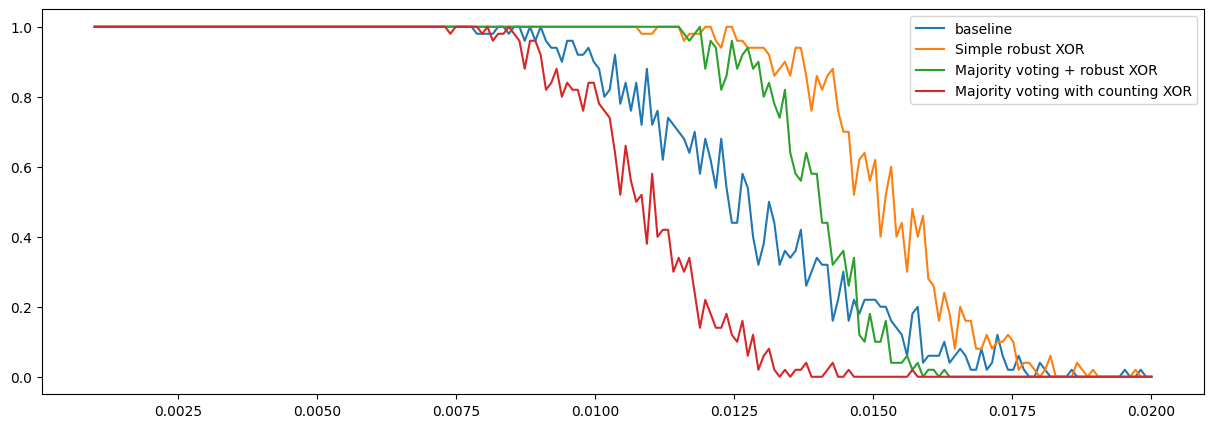

In [12]:
plt.figure(figsize = (15, 5))

for experiment in experiments:
    experiment_results = results_df[results_df["Experiment"]==experiment][["Standard Deviation", "Preservation Rate"]]
    plt.plot(experiment_results["Standard Deviation"], experiment_results["Preservation Rate"], label=experiment)

plt.locator_params(axis='x', nbins=10)
plt.legend()
plt.autoscale(True)
    

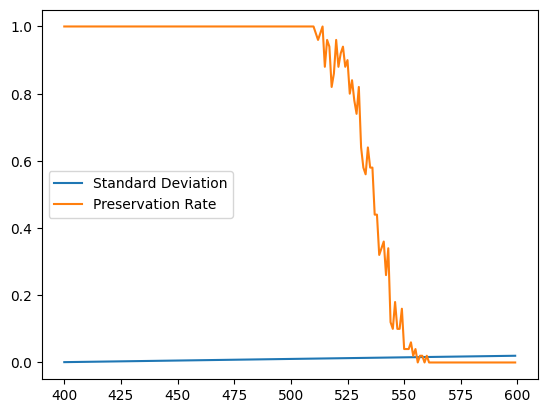

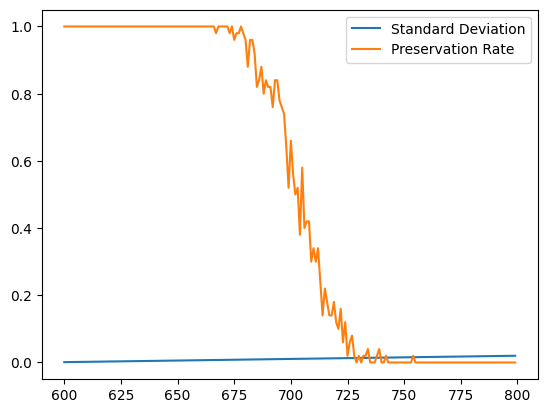

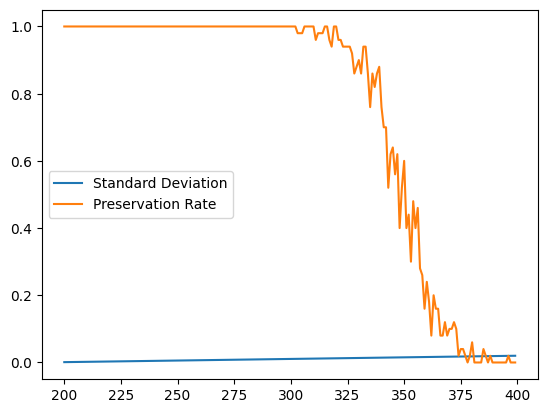

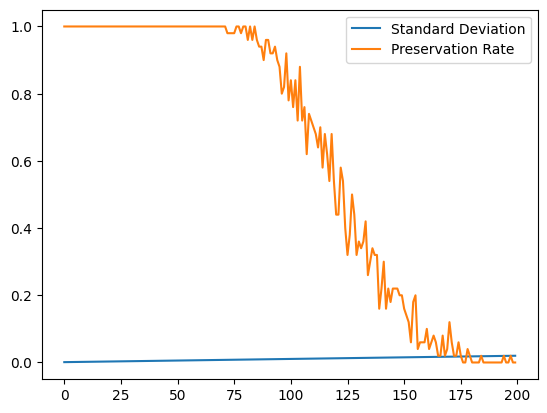

In [13]:
plot = results_df.groupby(["Experiment"]).plot()

In [14]:
plo

NameError: name 'plo' is not defined